# Synthetic Dataset Verification

In [1]:
#standard libraries
library(assertthat)
library(stringr)
library(pracma)
library(plyr)
library(dplyr)
library(tidyverse)
#regression libraries
library(lme4)
#plotting libraries
library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(scales)
library(repr)
#user functions
source(file.path('..','..','r_lib','auxiliary_functions.r'))

options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ purrr::cross()     masks pracma::cross()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ tibble::has_name() masks assertthat::has_name()
✖ dplyr::

### Plotting Setup

In [2]:
base_breaks <- function(n = 10){
  function(x) {
    axisTicks(log10(range(x, na.rm = TRUE)), log = TRUE, n = n)
  }
}
#log breaks
breaks_log       <- 10^(-10:10)
breaks_log_minor <- rep(1:9, 21)*(10^rep(-10:10, each=9))
#plotting theme
theme_set(theme_linedraw())

#text size
size_title <- 15
size_text  <- 12

#color palette
color_dW   <- "#666666"
color_dB   <- "#00BFC4"
color_dBP  <- "#4DAF4A"
color_dS2S <- "#F781BF"
color_dSP  <- "#FFFF33"
color_dT   <- "#F8766D"

### Define Variables

In [3]:
#EAS flatfile (removed outliers 2023-11-10)
fname_flatfile <- file.path('..','..','..','Raw_files','flatfiles','fas_flatfile_v2no_outliers_20231130.csv')

#scaling factor for random effects distance scaling
scl_rrup_rref <- 0.01

#UTM Zome
utm_zone <- '11S'

#Defined coefficients
c_intrcp <-  2.3
c_mag    <-  1.0
c_mag2   <- -0.2
c_gs     <- -1.0
c_rrup   <- -0.01
c_lnvs30 <- -0.65

#Aleatory Variability
tau    <- 0.6
phi    <- 0.5
phiS2S <- 0.3
#Distance Dependent Variability 
tauP    <- 0.002
phiP    <- 0.002

## Load Data

In [4]:
#read flatifle
df_syn_ds <- read_csv(fname_flatfile, show_col_types = FALSE)
#keep only relevant columns
df_syn_ds <- df_syn_ds[,c('motion_id','event_id','station_id','path_id','user_id','event_name','comcat_id','magnitude','ztor','vs30','rrup')]

colnames(df_syn_ds)
head(df_syn_ds) 

[1] "motion_id"  "event_id"   "station_id" "path_id"    "user_id"   
 [6] "event_name" "comcat_id"  "magnitude"  "ztor"       "vs30"      
[11] "rrup"

motion_id,event_id,station_id,path_id,user_id,event_name,comcat_id,magnitude,ztor,vs30,rrup
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
41,29,319,39,5,Lytle Creek,ci3323898,5.33,5.627,450.28,103.39
42,29,72,40,5,Lytle Creek,ci3323898,5.33,5.627,477.22,22.94
43,29,71,41,5,Lytle Creek,ci3323898,5.33,5.627,813.50,19.35
44,29,73,42,5,Lytle Creek,ci3323898,5.33,5.627,301.95,30.11
45,29,105,43,5,Lytle Creek,ci3323898,5.33,5.627,680.87,20.24
46,29,322,44,5,Lytle Creek,ci3323898,5.33,5.627,316.46,73.67


#### Compute Scaling Term

In [5]:
calc_scl_terms <- function(df_flt, mag='magnitude', rrup='rrup', vs30='vs30', scl_rrup_rref=1,
                           fun_mag_quad, fun_pseudo_depth){
    
    #rupture distance scaling
    df_flt[,'rrup']   <- df_flt[,rrup]
    #magnitude scaling
    df_flt[,'mag']    <- df_flt[,mag]
    #quadratic magnitude scaling
    df_flt[,'mag2']   <- fun_mag_quad(df_flt[,mag]) 
    #pseudo depth
    df_flt[,'pdepth'] <-  fun_pseudo_depth(df_flt$mag)
    #geometrical spreading
    df_flt[,'gs']     <-  log(df_flt$rrup + df_flt$pdepth)
    #site scaling
    df_flt[,'vs30']   <- df_flt[,vs30]
    df_flt[,'lnvs30'] <- log(df_flt[,vs30])
    
    #distance scaling for random effects
    df_flt['reff_rrup'] <- scl_rrup_rref * df_flt['rrup']
    
    return(df_flt)
}

#add utm coordinates

#custom scaling functions
fun_mag_quad     <- function(mag) (8.5-mag)^2 
fun_pseudo_depth <- function(mag)  5 * exp(0.4*(mag-6))

#compute scaling terms
df_syn_ds <- calc_scl_terms(df_syn_ds, scl_rrup_rref=scl_rrup_rref, fun_mag_quad=fun_mag_quad, fun_pseudo_depth=fun_pseudo_depth)

#### Initialize Dataset

In [6]:
#intitialize random effects
df_syn_ds_eq <- data.frame(event_id=unique(df_syn_ds$event_id))     #event random effects
df_syn_ds_eq <- df_syn_ds_eq %>% left_join(df_syn_ds[,c('event_id','event_name','comcat_id','magnitude')], by='event_id', multiple='first')
df_syn_ds_st <- data.frame(station_id=unique(df_syn_ds$station_id)) #station random effects
df_syn_ds_st <- df_syn_ds_st %>% left_join(df_syn_ds[,c('station_id','vs30')], by='station_id', multiple='first')

#initialize coefficinet dataframe
df_gmm_coeffs <- as.data.frame(t(c(c_intrcp,c_mag,c_mag2,c_gs,c_rrup,c_lnvs30,tau,tauP,phi,phiS2S,phiP)),
                               row.names='gmm_syn')
colnames(df_gmm_coeffs) <- c('(Intercept)','mag','mag2','gs','rrup','lnvs30','tau','tauP','phi','phiS2S','phiP')

### Synthetic Dataset

In [7]:
#median ground motion
df_syn_ds$med <- c_intrcp + c_mag * df_syn_ds$mag + c_mag2 * df_syn_ds$mag2 + c_gs * df_syn_ds$gs + c_rrup * df_syn_ds$rrup + c_lnvs30 * df_syn_ds$lnvs30

#within event variability
df_syn_ds$dW <- rnorm(nrow(df_syn_ds), sd=phi)

#random effects conditioned on event id
df_syn_ds_eq$dB   <- rnorm(nrow(df_syn_ds_eq), sd=tau)
df_syn_ds_eq$dBP  <- rnorm(nrow(df_syn_ds_eq), sd=tauP)
#random effects conditioned on station id
df_syn_ds_st$dS2S <- rnorm(nrow(df_syn_ds_st), sd=phiS2S)
df_syn_ds_st$dSP  <- rnorm(nrow(df_syn_ds_st), sd=phiP)

#merge random effects on synthetic dataset
df_syn_ds <- df_syn_ds %>% left_join(df_syn_ds_eq[c('event_id','dB','dBP')],     by='event_id')
df_syn_ds <- df_syn_ds %>% left_join(df_syn_ds_st[c('station_id','dS2S','dSP')], by='station_id')

#compute response variable
df_syn_ds$y_erg_req <- df_syn_ds$med + df_syn_ds$dW + df_syn_ds$dB + df_syn_ds$dS2S +  df_syn_ds$rrup * df_syn_ds$dBP
df_syn_ds$y_erg_rst <- df_syn_ds$med + df_syn_ds$dW + df_syn_ds$dB + df_syn_ds$dS2S +  df_syn_ds$rrup * df_syn_ds$dSP
df_syn_ds$y_ss_req  <- df_syn_ds$med + df_syn_ds$dW + df_syn_ds$dB + df_syn_ds$dS2S +  df_syn_ds$rrup * df_syn_ds$dBP
df_syn_ds$y_ss_rst  <- df_syn_ds$med + df_syn_ds$dW + df_syn_ds$dB + df_syn_ds$dS2S +  df_syn_ds$rrup * df_syn_ds$dSP

## Regression 
#### Regression Formulas

In [8]:
#GMM Ergodic: event dependent linear distance aleatory term
#aleat: deltaB_e + deltaS2S_s + rrup * deltaEP_e + deltaW_es
frm_gmm_erg_req <- 'y_erg_req ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup|event_id)'

#GMM Ergodic: station dependent linear distance aleatory term
#aleat: deltaB_e + deltaS2S_s + rrup * deltaSP_s + deltaW_es
frm_gmm_erg_rst <- 'y_erg_rst ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1            |event_id) + (0 + reff_rrup|station_id)'

#GMM Single-Station: event dependent linear distance aleatory term
#aleat: deltaB_e + deltaS2S_s + rrup * deltaEP_e + deltaW_es
frm_gmm_ss_req  <- 'y_ss_req ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup|event_id) + (1            |station_id)'

#GMM Single-Station: station dependent linear distance aleatory term
#aleat: deltaB_e + deltaS2S_s + rrup * deltaSP_s + deltaW_es
frm_gmm_ss_rst  <- 'y_ss_rst ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1            |event_id) + (1 + reff_rrup|station_id)'

#### Ergodic Model with Event Dependent Distance Proportional Aleatory Variability

In [9]:
#run regression
fit_gmm_erg_req <- lmer(frm_gmm_erg_req, df_syn_ds)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_erg_req)), row.names='gmm_erg_req'))
df_gmm_coeffs['gmm_erg_req','phi']    <- sigma(fit_gmm_erg_req)
df_gmm_coeffs['gmm_erg_req','tau']    <- sqrt(VarCorr(fit_gmm_erg_req)$event_id[1,1])
df_gmm_coeffs['gmm_erg_req','tauP']   <- sqrt(VarCorr(fit_gmm_erg_req)$event_id[2,2]) * scl_rrup_rref

df_syn_ds[,'gmm_erg_req_dW'] <- residuals(fit_gmm_erg_req)

df_syn_ds_eq <- merge(df_syn_ds_eq,                 ranef(fit_gmm_erg_req)$event_id['(Intercept)'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_erg_req_dB' = '(Intercept)')
df_syn_ds_eq <- merge(df_syn_ds_eq, scl_rrup_rref * ranef(fit_gmm_erg_req)$event_id['reff_rrup'],     by.x='event_id', by.y=0) %>% 
                    rename('gmm_erg_req_dBP' = 'reff_rrup')

#regression summary
summary(fit_gmm_erg_req)

Linear mixed model fit by REML ['lmerMod']
Formula: y_erg_req ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup |  
    event_id)
   Data: df_syn_ds

REML criterion at convergence: 40991.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9994 -0.6693 -0.0060  0.6696  3.9929 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 event_id (Intercept) 0.34554  0.5878        
          reff_rrup   0.04288  0.2071   -0.14
 Residual             0.33546  0.5792        
Number of obs: 22675, groups:  event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -0.0250258  1.4675182  -0.017
mag          1.3704985  0.2079532   6.590
mag2        -0.1534731  0.0310885  -4.937
gs          -1.0236784  0.0149174 -68.623
rrup        -0.0098118  0.0002205 -44.507
lnvs30      -0.6469139  0.0107704 -60.064

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs     rrup  
mag    -0.996                            
mag2   -0.992  0.984             

#### Ergodic with Station Dependent Distance Proportional Aleatory Variability

In [10]:
#run regression
fit_gmm_erg_rst <- lmer(frm_gmm_erg_rst, df_syn_ds)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_erg_rst)), row.names='gmm_erg_rst'))
df_gmm_coeffs['gmm_erg_rst','phi']     <- sigma(fit_gmm_erg_rst)
df_gmm_coeffs['gmm_erg_rst','tau']     <- sqrt(VarCorr(fit_gmm_erg_rst)$event_id[1,1])
df_gmm_coeffs['gmm_erg_rst','phiP']    <- sqrt(VarCorr(fit_gmm_erg_rst)$station_id[1,1]) * scl_rrup_rref

df_syn_ds[,'gmm_erg_rst_dW'] <- residuals(fit_gmm_erg_rst)

df_syn_ds_eq <- merge(df_syn_ds_eq,                 ranef(fit_gmm_erg_rst)$event_id['(Intercept)'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_erg_rst_dB' = '(Intercept)')
df_syn_ds_st <- merge(df_syn_ds_st, scl_rrup_rref * ranef(fit_gmm_erg_rst)$station_id['reff_rrup'],   by.x='station_id', by.y=0) %>% 
                    rename('gmm_erg_rst_dSP' =  'reff_rrup')

#regression summary
summary(fit_gmm_erg_rst)

Linear mixed model fit by REML ['lmerMod']
Formula: y_erg_rst ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 | event_id) +  
    (0 + reff_rrup | station_id)
   Data: df_syn_ds

REML criterion at convergence: 40278.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8893 -0.6260 -0.0072  0.6266  3.7867 

Random effects:
 Groups     Name        Variance Std.Dev.
 station_id reff_rrup   0.06744  0.2597  
 event_id   (Intercept) 0.33860  0.5819  
 Residual               0.27963  0.5288  
Number of obs: 22675, groups:  station_id, 4414; event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -0.2703610  1.4538843  -0.186
mag          1.3981286  0.2059198   6.790
mag2        -0.1478065  0.0307862  -4.801
gs          -1.0129670  0.0129230 -78.385
rrup        -0.0099534  0.0001511 -65.877
lnvs30      -0.6483608  0.0149755 -43.295

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs     rrup  
mag    -0.995                            
mag2   -0.99

#### Single Station Model with Event Dependent Distance Proportional Aleatory Variability

In [11]:
#run regression
fit_gmm_ss_req <- lmer(frm_gmm_ss_req, df_syn_ds)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_ss_req)), row.names='gmm_ss_req'))
df_gmm_coeffs['gmm_ss_req','phi']    <- sigma(fit_gmm_ss_req)
df_gmm_coeffs['gmm_ss_req','tau']    <- sqrt(VarCorr(fit_gmm_ss_req)$event_id[1,1])
df_gmm_coeffs['gmm_ss_req','tauP']   <- sqrt(VarCorr(fit_gmm_ss_req)$event_id[2,2]) * scl_rrup_rref
df_gmm_coeffs['gmm_ss_req','phiS2S'] <- sqrt(VarCorr(fit_gmm_ss_req)$station_id[1,1])

df_syn_ds[,'gmm_ss_req_dW'] <- residuals(fit_gmm_ss_req)

df_syn_ds_eq <- merge(df_syn_ds_eq,                 ranef(fit_gmm_ss_req)$event_id['(Intercept)'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_ss_req_dB' = '(Intercept)')
df_syn_ds_eq <- merge(df_syn_ds_eq, scl_rrup_rref * ranef(fit_gmm_ss_req)$event_id['reff_rrup'],     by.x='event_id', by.y=0) %>% 
                    rename('gmm_ss_req_dBP' = 'reff_rrup')
df_syn_ds_st <- merge(df_syn_ds_st,                 ranef(fit_gmm_ss_req)$station_id['(Intercept)'], by.x='station_id', by.y=0) %>% 
                    rename('gmm_ss_req_dS2S' ='(Intercept)')

#regression summary
summary(fit_gmm_ss_req)

Linear mixed model fit by REML ['lmerMod']
Formula: y_ss_req ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup |  
    event_id) + (1 | station_id)
   Data: df_syn_ds

REML criterion at convergence: 37613.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8180 -0.6374 -0.0033  0.6361  3.8422 

Random effects:
 Groups     Name        Variance Std.Dev. Corr 
 station_id (Intercept) 0.08603  0.2933        
 event_id   (Intercept) 0.34198  0.5848        
            reff_rrup   0.04324  0.2079   -0.12
 Residual               0.25043  0.5004        
Number of obs: 22675, groups:  station_id, 4414; event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -0.5401291  1.4659638  -0.368
mag          1.4084941  0.2073415   6.793
mag2        -0.1478303  0.0309934  -4.770
gs          -0.9885284  0.0144560 -68.382
rrup        -0.0101874  0.0002186 -46.596
lnvs30      -0.6277239  0.0174945 -35.881

Correlation of Fixed Effects:
       (Intr) mag    mag2

#### Single Station Model with Station Dependent Distance Proportional Aleatory Variability

In [12]:
#run regression
fit_gmm_ss_rst <- lmer(frm_gmm_ss_rst, df_syn_ds)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_ss_rst)), row.names='gmm_ss_rst'))
df_gmm_coeffs['gmm_ss_rst','phi']     <- sigma(fit_gmm_ss_rst)
df_gmm_coeffs['gmm_ss_rst','tau']     <- sqrt(VarCorr(fit_gmm_ss_rst)$event_id[1,1])
df_gmm_coeffs['gmm_ss_rst','phiS2S']  <- sqrt(VarCorr(fit_gmm_ss_rst)$station_id[1,1])
df_gmm_coeffs['gmm_ss_rst','phiP']    <- sqrt(VarCorr(fit_gmm_ss_rst)$station_id[2,2]) * scl_rrup_rref

df_syn_ds[,'gmm_ss_rst_dW'] <- residuals(fit_gmm_ss_rst)

df_syn_ds_eq <- merge(df_syn_ds_eq,                 ranef(fit_gmm_ss_rst)$event_id['(Intercept)'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_ss_rst_dB' = '(Intercept)')
df_syn_ds_st <- merge(df_syn_ds_st,                 ranef(fit_gmm_ss_rst)$station_id['(Intercept)'], by.x='station_id', by.y=0) %>% 
                    rename('gmm_ss_rst_dS2S' = '(Intercept)')
df_syn_ds_st <- merge(df_syn_ds_st, scl_rrup_rref * ranef(fit_gmm_ss_rst)$station_id['reff_rrup'],   by.x='station_id', by.y=0) %>% 
                    rename('gmm_ss_rst_dSP' =  'reff_rrup')

#regression summary
summary(fit_gmm_ss_rst)

Linear mixed model fit by REML ['lmerMod']
Formula: y_ss_rst ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 | event_id) +  
    (1 + reff_rrup | station_id)
   Data: df_syn_ds

REML criterion at convergence: 39196.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8677 -0.6250 -0.0081  0.6212  3.7152 

Random effects:
 Groups     Name        Variance Std.Dev. Corr
 station_id (Intercept) 0.08500  0.2915       
            reff_rrup   0.03933  0.1983   0.02
 event_id   (Intercept) 0.33780  0.5812       
 Residual               0.25038  0.5004       
Number of obs: 22675, groups:  station_id, 4414; event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -0.5310194  1.4552643  -0.365
mag          1.4134809  0.2057418   6.870
mag2        -0.1458295  0.0307616  -4.741
gs          -1.0002029  0.0134542 -74.341
rrup        -0.0100061  0.0001468 -68.169
lnvs30      -0.6319131  0.0197264 -32.034

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs

### Summary Results
#### Comparison Fixed Effect Coefficients

In [13]:
df_gmm_coeffs

,(Intercept),mag,mag2,gs,rrup,lnvs30,tau,tauP,phi,phiS2S,phiP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gmm_syn,2.30000000,1.000000,-0.2000000,-1.0000000,-0.010000000,-0.6500000,0.6000000,0.002000000,0.5000000,0.3000000,0.002000000
gmm_erg_req,-0.02502584,1.370498,-0.1534731,-1.0236784,-0.009811795,-0.6469139,0.5878235,0.002070763,0.5791902,NA,NA
gmm_erg_rst,-0.27036098,1.398129,-0.1478065,-1.0129670,-0.009953436,-0.6483608,0.5818928,NA,0.5287986,NA,0.002596864
gmm_ss_req,-0.54012907,1.408494,-0.1478303,-0.9885284,-0.010187373,-0.6277239,0.5847906,0.002079310,0.5004303,0.2933040,NA
gmm_ss_rst,-0.53101941,1.413481,-0.1458295,-1.0002029,-0.010006114,-0.6319131,0.5812082,NA,0.5003782,0.2915467,0.001983207


#### Ergodic Model with Event Dependent Distance Proportional Aleatory Variability

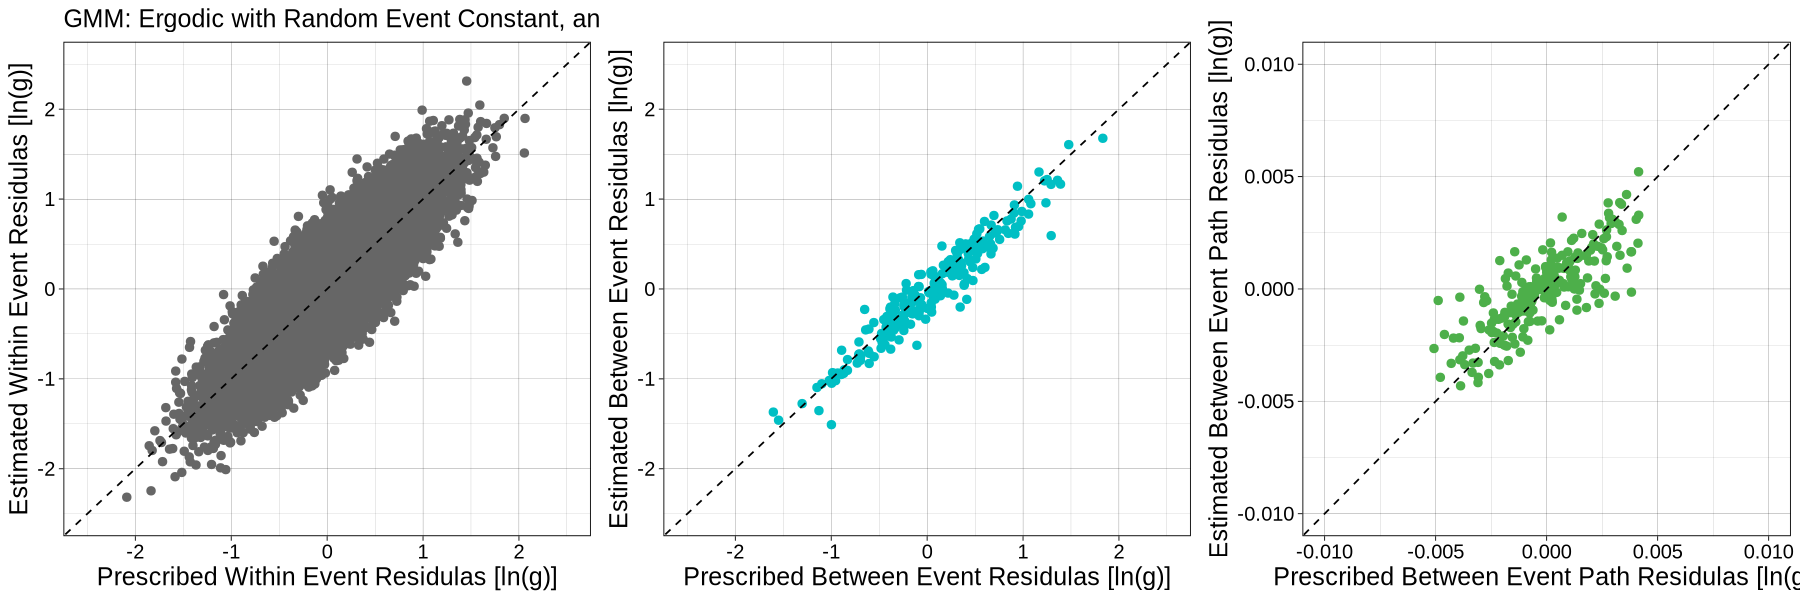

In [14]:
title_name <- 'GMM: Ergodic with Random Event Constant, and Event Distance Term'
pl_gmm_erg_req_dW_verif <- ggplot(data=df_syn_ds, aes(x=dW, y=gmm_erg_req_dW)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Within Event Residulas [ln(g)]', y='Estimated Within Event Residulas [ln(g)]', title=title_name) +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dW)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_req_dB_verif <- ggplot(data=df_syn_ds_eq, aes(x=dB, y=gmm_erg_req_dB)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Between Event Residulas [ln(g)]', y='Estimated Between Event Residulas [ln(g)]', title='') +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dB)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_req_dBP_verif <- ggplot(data=df_syn_ds_eq, aes(x=dBP, y=gmm_erg_req_dBP)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Between Event Path Residulas [ln(g)]', y='Estimated Between Event Path Residulas [ln(g)]', title='') +
                                    xlim(-0.01, 0.01)+ ylim(-0.01, 0.01) +
                                    scale_color_manual(values=c(color_dBP)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

options(repr.plot.width=5*3, repr.plot.height=5)
ggarrange(pl_gmm_erg_req_dW_verif, pl_gmm_erg_req_dB_verif,  pl_gmm_erg_req_dBP_verif, ncol=3, nrow=1)

#### Ergodic Model with Site Dependent Distance Proportional Aleatory Variability

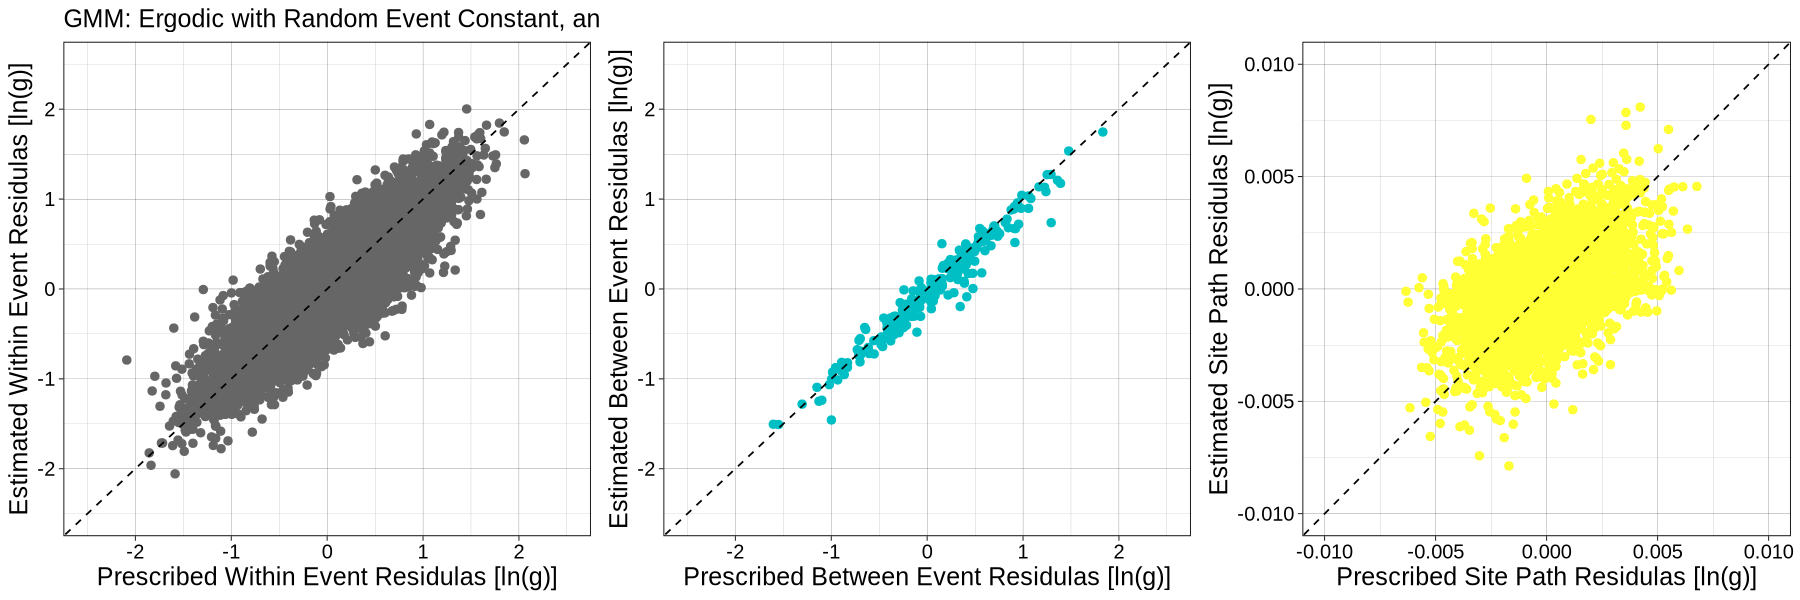

In [15]:
title_name <- 'GMM: Ergodic with Random Event Constant, and Site Distance Term'
pl_gmm_erg_rst_dW_verif <- ggplot(data=df_syn_ds, aes(x=dW, y=gmm_erg_rst_dW)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Within Event Residulas [ln(g)]', y='Estimated Within Event Residulas [ln(g)]', title=title_name) +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dW)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_rst_dB_verif <- ggplot(data=df_syn_ds_eq, aes(x=dB, y=gmm_erg_rst_dB)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Between Event Residulas [ln(g)]', y='Estimated Between Event Residulas [ln(g)]', title='') +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dB)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_rst_dSP_verif <- ggplot(data=df_syn_ds_st, aes(x=dSP, y=gmm_erg_rst_dSP)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Site Path Residulas [ln(g)]', y='Estimated Site Path Residulas [ln(g)]', title='') +
                                    xlim(-0.01, 0.01)+ ylim(-0.01, 0.01) +
                                    scale_color_manual(values=c(color_dSP)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

options(repr.plot.width=5*3, repr.plot.height=5)
ggarrange(pl_gmm_erg_rst_dW_verif, pl_gmm_erg_rst_dB_verif,  pl_gmm_erg_rst_dSP_verif, ncol=3, nrow=1)

#### Single Station Model with Event Dependent Distance Proportional Aleatory Variability

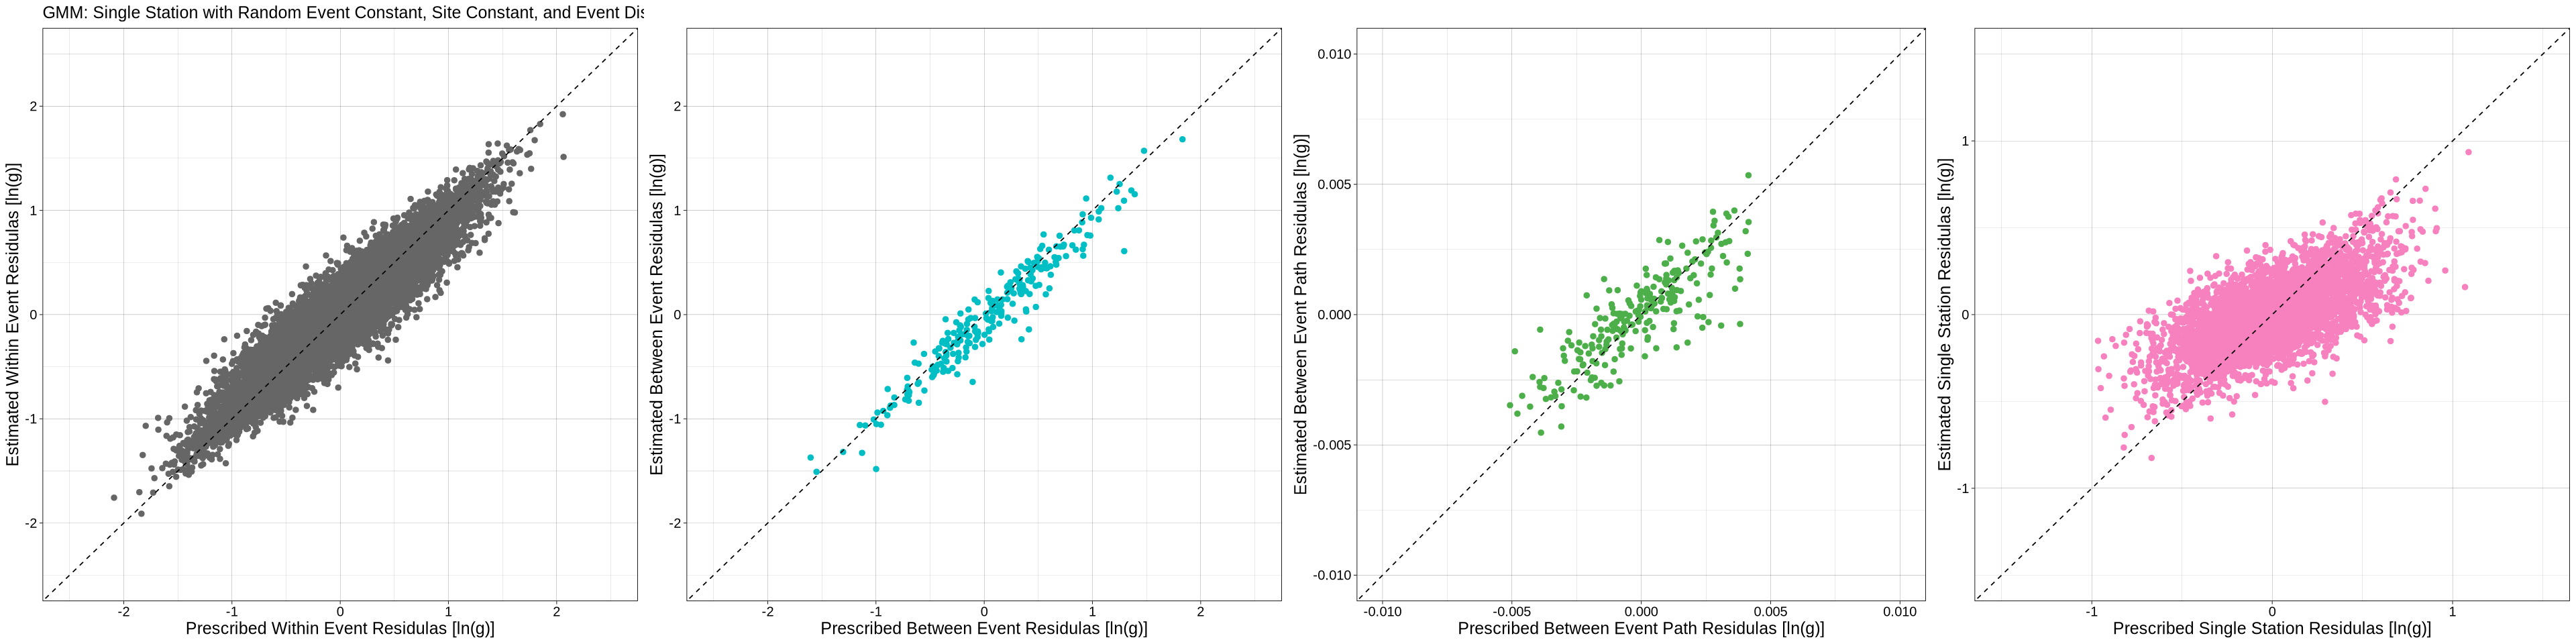

In [16]:
title_name <- 'GMM: Single Station with Random Event Constant, Site Constant, and Event Distance Term'
pl_gmm_ss_req_dW_verif <- ggplot(data=df_syn_ds, aes(x=dW, y=gmm_ss_req_dW)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Within Event Residulas [ln(g)]', y='Estimated Within Event Residulas [ln(g)]', title=title_name) +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dW)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_ss_req_dB_verif <- ggplot(data=df_syn_ds_eq, aes(x=dB, y=gmm_ss_req_dB)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Between Event Residulas [ln(g)]', y='Estimated Between Event Residulas [ln(g)]', title='') +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dB)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_ss_req_dBP_verif <- ggplot(data=df_syn_ds_eq, aes(x=dBP, y=gmm_ss_req_dBP)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Between Event Path Residulas [ln(g)]', y='Estimated Between Event Path Residulas [ln(g)]', title='') +
                                    xlim(-0.01, 0.01)+ ylim(-0.01, 0.01) +
                                    scale_color_manual(values=c(color_dBP)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_ss_req_dS2S_verif <- ggplot(data=df_syn_ds_st, aes(x=dS2S, y=gmm_ss_req_dS2S)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Single Station Residulas [ln(g)]', y='Estimated Single Station Residulas [ln(g)]', title='') +
                                    xlim(-1.5, 1.5)+ ylim(-1.5, 1.5) +
                                    scale_color_manual(values=c(color_dS2S)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

options(repr.plot.width=8*4, repr.plot.height=8)
ggarrange(pl_gmm_ss_req_dW_verif, pl_gmm_ss_req_dB_verif,  pl_gmm_ss_req_dBP_verif, pl_gmm_ss_req_dS2S_verif, ncol=4, nrow=1)

#### Single Station Model with Site Dependent Distance Proportional Aleatory Variability

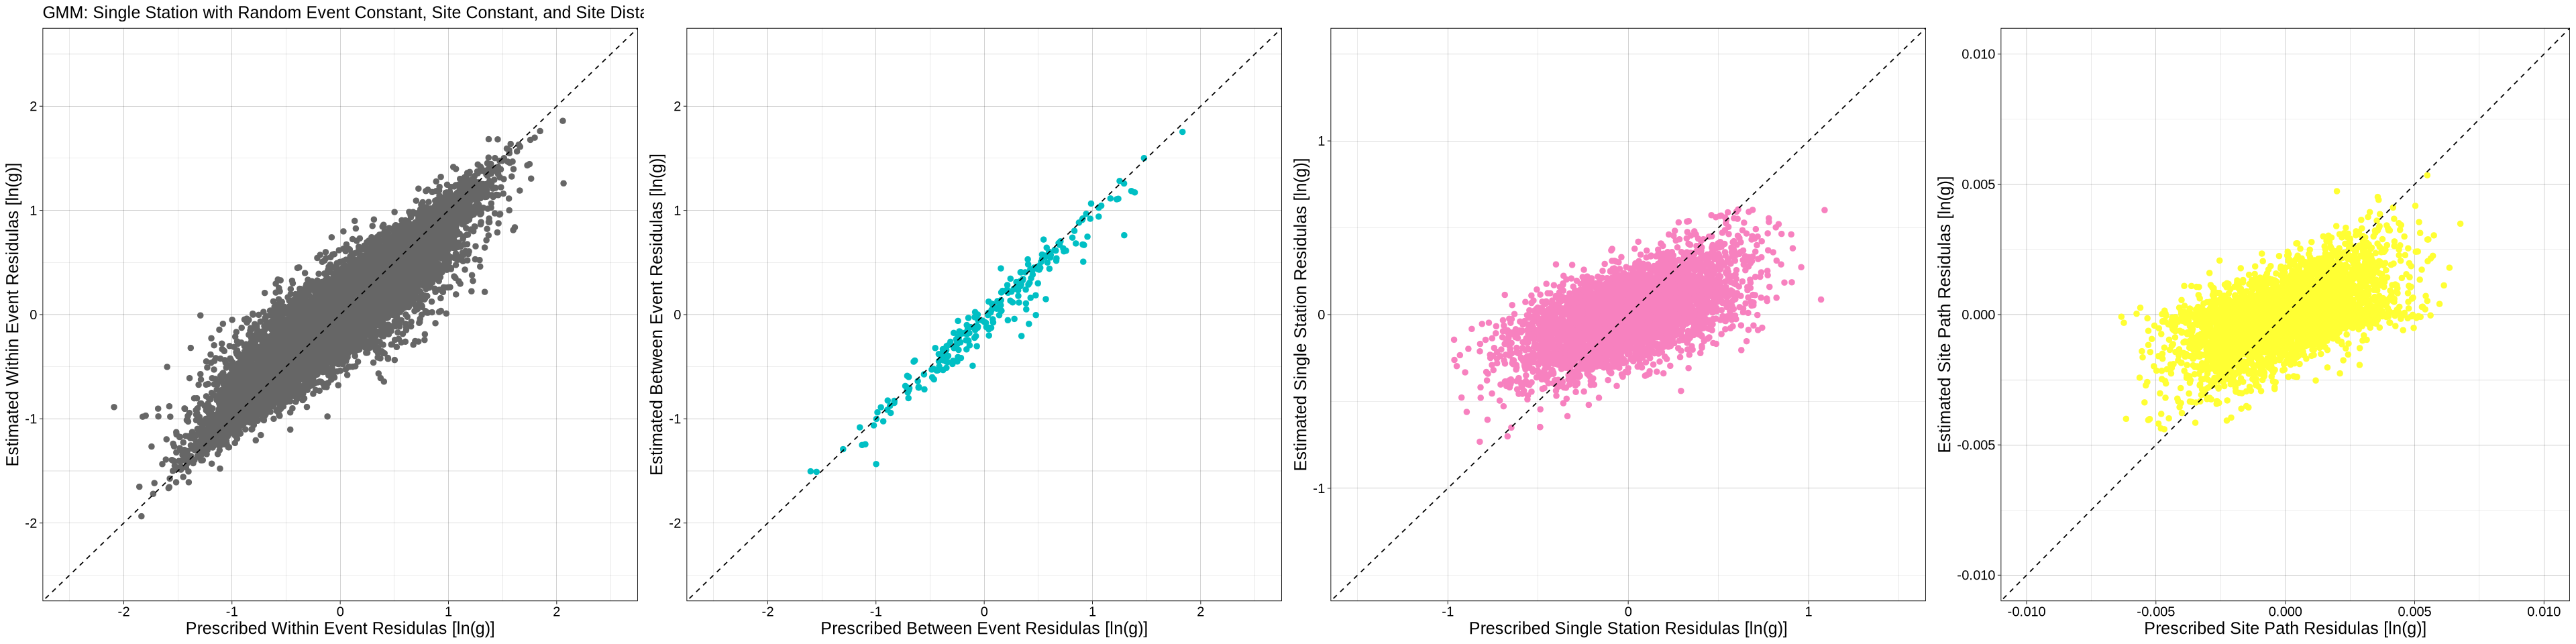

In [17]:
title_name <- 'GMM: Single Station with Random Event Constant, Site Constant, and Site Distance Term'
pl_gmm_ss_rst_dW_verif <- ggplot(data=df_syn_ds, aes(x=dW, y=gmm_ss_rst_dW)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Within Event Residulas [ln(g)]', y='Estimated Within Event Residulas [ln(g)]', title=title_name) +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dW)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_ss_rst_dB_verif <- ggplot(data=df_syn_ds_eq, aes(x=dB, y=gmm_ss_rst_dB)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Between Event Residulas [ln(g)]', y='Estimated Between Event Residulas [ln(g)]', title='') +
                                    xlim(-2.5, 2.5)+ ylim(-2.5, 2.5) +
                                    scale_color_manual(values=c(color_dB)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_ss_rst_dS2S_verif <- ggplot(data=df_syn_ds_st, aes(x=dS2S, y=gmm_ss_rst_dS2S)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Single Station Residulas [ln(g)]', y='Estimated Single Station Residulas [ln(g)]', title='') +
                                    xlim(-1.5, 1.5)+ ylim(-1.5, 1.5) +
                                    scale_color_manual(values=c(color_dS2S)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_ss_rst_dSP_verif <- ggplot(data=df_syn_ds_st, aes(x=dSP, y=gmm_ss_rst_dSP)) + geom_point(aes(color=as.factor(1)), size=2) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Prescribed Site Path Residulas [ln(g)]', y='Estimated Site Path Residulas [ln(g)]', title='') +
                                    xlim(-0.01, 0.01)+ ylim(-0.01, 0.01) +
                                    scale_color_manual(values=c(color_dSP)) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

options(repr.plot.width=8*4, repr.plot.height=8)
ggarrange(pl_gmm_ss_rst_dW_verif, pl_gmm_ss_rst_dB_verif, pl_gmm_ss_rst_dS2S_verif,  pl_gmm_ss_rst_dSP_verif, ncol=4, nrow=1)